<a href="https://colab.research.google.com/github/kyw061827/Yewon-KIM/blob/main/GEE_0082_sen2_turbidity_Tajikistan_Karakul_Lake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# -*- coding: utf-8 -*-
"""GEE_0082_sen2_turbidity_Tajikistan.ipynb

타지키스탄 카라쿨 호수의 물 탁도 매핑 및 모니터링을 위해 수정된 코드입니다.
FYI, 카라쿨 호수:타지키스탄에서 가장 큰 자연 저수지입니다.동부 파미르 지역에 있으며 해발고도가 \(3km\) 이상인 고지에 있습니다.겨울에는 두께가 \(1\)m 이상인 얼음으로 덮이기도 합니다.

원본 튜토리얼: Google Earth Engine Tutorial-164: Sentinel-2 Water Turbidity Mapping and Monitoring using Python API (Xee)
"""

import ee
import geemap
import xarray as xr
!pip install xee
import xee

<>:5: SyntaxWarning: invalid escape sequence '\('
<>:5: SyntaxWarning: invalid escape sequence '\('


/tmp/ipython-input-937016358.py:5: SyntaxWarning: invalid escape sequence '\('
  FYI, 카라쿨 호수:타지키스탄에서 가장 큰 자연 저수지입니다.동부 파미르 지역에 있으며 해발고도가 \(3km\) 이상인 고지에 있습니다.겨울에는 두께가 \(1\)m 이상인 얼음으로 덮이기도 합니다.


In [38]:
# Google Earth Engine 초기화
# YOUR_GEE_PROJECT_ID를 사용자 본인의 GEE 프로젝트 ID로 변경하세요.
# 예: project = 'ee-my-personal-project'
ee.Authenticate()
ee.Initialize(
    project = 'my-gee-project-tjk-turbidity', # <-- 이 부분을 사용자의 GEE 프로젝트 ID로 변경하세요.
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

In [39]:
# 🗺️ 타지키스탄의 관심 영역(ROI) 정의
# 타지키스탄의 대략적인 경계 좌표 (Bounding Box)
# [서경, 남위, 동경, 북위]
# 대략적 좌표: [67.0, 36.5, 75.0, 41.0]
# 수정: 카라쿨 호수 주변의 좌표 (대략 [73.2, 38.8, 73.8, 39.2])
karakul_bbox = [73.2, 38.8, 73.8, 39.2] # 카라쿨 호수 주변의 Bounding Box로 변경
roi = ee.Geometry.BBox(*karakul_bbox)

In [40]:

# 지도 객체는 필수는 아니지만, ROI를 시각화하기 위해 생성할 수 있습니다.
# map = geemap.Map(center=[38.8, 71.0], zoom=6, basemap='SATELLITE')
# map.add_layer(roi, {'color': 'red'}, 'Tajikistan ROI')
# map

# 💧 물 탁도(Turbidity) 계산 함수 (NDTI 기반)
# 원본 코드 유지
def turbidity(img):
    # 구름 마스킹 (확률 20% 미만)
    cloud = img.select('probability')
    cloud_free = cloud.lt(20)

    # Sentinel-2 표면 반사율 스케일링
    sr = img.select('B.*').multiply(0.0001)

    # NDWI 계산 (B3: 녹색, B8: NIR) - 물 영역 식별
    ndwi = sr.normalizedDifference(['B3','B8']).rename('ndwi')
    water_body = ndwi.gt(0.1) # NDWI 0.1 이상을 물로 간주

    # NDTI 계산 (정규화된 탁도 지수)
    # NDTI = (Red - Green) / (Red + Green) => (B4 - B3) / (B4 + B3)
    ndti = sr.normalizedDifference(['B4','B3']).rename('ndti')

    # 구름 및 물 영역 마스크 적용
    return ndti.updateMask(cloud_free).updateMask(water_body).copyProperties(img, ['system:time_start'])

In [41]:
sen2 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .linkCollection(ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY"), 'probability')
    .filterBounds(roi) # 타지키스탄 ROI로 변경
    .filterDate('2025-06-01','2025-11-16') # 날짜 범위 설정
    .map(turbidity) # 탁도 함수 적용
)

In [50]:
# 🖼️ Xee를 사용하여 GEE ImageCollection을 Xarray Dataset으로 변환
# 주의: 이 과정은 데이터 양에 따라 시간이 오래 걸리거나 Colab 메모리 제한을 초과할 수 있습니다.
# 계산 부하를 줄이기 위해 scale을 0.01로 조정합니다. (약 1.1km 해상도)
# 더 높은 해상도를 원하면 scale을 줄여야 하지만, Colab에서 실패할 가능성이 높습니다.
ds = xr.open_dataset(
    sen2,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.005, # <-- 해상도를 0.005 (약 550m)로 높여봅니다.
    geometry = roi
)

In [51]:
# 시간 순서로 정렬하고 값 조정 (원본 코드 유지)
ds = ds.sortby('time') * 1

In [53]:
# 📅 월별 최대 탁도 값 계산
ds_monthly = ds.resample(time = 'M').max('time')
print(ds_monthly)

<xarray.Dataset> Size: 232kB
Dimensions:  (time: 6, lon: 120, lat: 80)
Coordinates:
  * time     (time) datetime64[ns] 48B 2025-06-30 2025-07-31 ... 2025-11-30
  * lon      (lon) float64 960B 73.2 73.21 73.21 73.22 ... 73.79 73.79 73.8
  * lat      (lat) float64 640B 38.8 38.81 38.81 38.82 ... 39.19 39.19 39.2
Data variables:
    ndti     (time, lon, lat) float32 230kB nan nan nan nan ... nan nan nan nan
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name: 

/usr/local/lib/python3.12/dist-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


월별 탁도 맵을 시각화합니다...


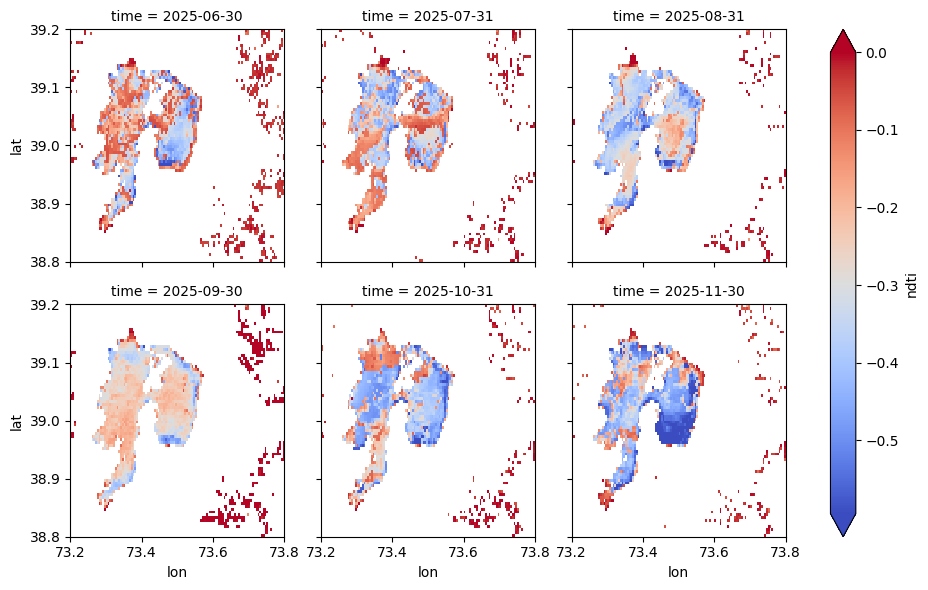

In [54]:
# 📊 월별 탁도 맵 시각화
# Colab 환경에서는 맵의 개수에 따라 시각화에 시간이 걸릴 수 있습니다.
print("월별 탁도 맵을 시각화합니다...")
ds_monthly.ndti.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    robust = True,
    col_wrap = 3, # 열 개수를 4개로 조정
    cmap = 'coolwarm', # 색상표 (차가움: 낮음, 따뜻함: 높음)
    vmax = 0 # 탁도 지수 최대값 설정
)


In [46]:
# 📈 타지키스탄 전체 평균 탁도 시계열 데이터프레임 추출
ds_mean = ds_monthly.mean(dim = ['lat','lon']).to_dataframe()

In [47]:
# 💾 결과를 CSV 파일로 저장
ds_mean.to_csv('turbidity_karakul_monthly_mean.csv')

print("\n'turbidity_karakul_monthly_mean.csv' 파일이 저장되었습니다.")


'turbidity_karakul_monthly_mean.csv' 파일이 저장되었습니다.


In [48]:
print("Normalized Difference Turbidity Index(NDTI):")

Normalized Difference Turbidity Index(NDTI):


In [49]:
print(ds_mean)
#2025년 6월부터 11월까지의 월별 평균 탁도(NDTI 값)를 살펴보면 대체로 낮아지는 경향을 보이지만, 중간에 약간의 변동이 있습니다.
#NDTI 값이 음수 방향으로 더 커질수록(더 작은 값일수록) 탁도는 **낮아진다(물이 맑아진다)**고 해석할 수 있습니다.
#따라서 6월부터 8월까지는 탁도가 지속적으로 낮아지다가, 9월에 다시 조금 높아졌고, 이후 10월과 11월에는 다시 낮아져 전체 기간 중 가장 낮은 탁도를 보였습니다.
#전반적으로는 계절이 갈수록 물이 맑아지는 경향을 보였다고 할 수 있습니다.

                ndti
time                
2025-06-30 -0.199797
2025-07-31 -0.221783
2025-08-31 -0.294800
2025-09-30 -0.210757
2025-10-31 -0.293106
2025-11-30 -0.346431


In [55]:
import io
import sys
from contextlib import redirect_stdout

# 출력을 저장할 파일 경로 설정
output_filename = 'print_output.txt'

# StringIO 객체를 생성하여 print 출력을 임시로 저장
f = io.StringIO()

# redirect_stdout을 사용하여 print 출력을 f 객체로 리다이렉션
with redirect_stdout(f):
    print("--- Normalized Difference Turbidity Index(NDTI) ---")
    print(ds_mean)
    print("\n--- Monthly Turbidity Data (ds_monthly preview) ---")
    # ds_monthly는 매우 클 수 있으므로, 전체를 출력하기보다는 구조만 확인하거나,
    # 필요한 경우 일부만 출력하는 것이 좋습니다. 여기서는 간단히 객체 정보만 출력합니다.
    print(ds_monthly)

# StringIO에 저장된 내용을 가져와 파일에 씁니다.
with open(output_filename, 'w', encoding='utf-8') as output_file:
    output_file.write(f.getvalue())

print(f"모든 print() 결과가 '{output_filename}' 파일에 저장되었습니다.")

모든 print() 결과가 'print_output.txt' 파일에 저장되었습니다.


이 코드를 실행하면 `print_output.txt` 파일이 생성되며, 여기에 `print()`로 출력된 내용들이 저장됩니다. Colab의 왼쪽 파일 탐색기에서 이 파일을 확인하고 다운로드할 수 있습니다.